<a href="https://colab.research.google.com/github/chrisrichardson/fenics-tutorial/blob/main/spring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear elasticity example

Solves a problem on a 3D printed spring, computing displacement for an applied load.



In [15]:
# Install FEniCSx packages
try:
    import dolfinx
except ImportError:
    !wget -q -nc "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh" >& err.log
    import dolfinx


In [16]:
# General imports for MPI, numerics
from mpi4py import MPI
import numpy as np
from scipy.sparse.linalg import spsolve

# For visualisation
import pyvista
pyvista.global_theme.jupyter_backend = 'static'
pyvista.global_theme.notebook = True

# FEniCS imports
import ufl
from ufl import Identity, sym, grad, tr, dx, TestFunction, TrialFunction, Measure, inner

from dolfinx.io import XDMFFile
from dolfinx.plot import vtk_mesh
from dolfinx.fem import functionspace, dirichletbc, locate_dofs_topological
from dolfinx.fem import form, Constant, Function, Expression, assemble_scalar
from dolfinx.fem import assemble_matrix, assemble_vector, apply_lifting


## Download the mesh file
The mesh was generated using the onshape CAD system, and meshed with gmsh. The mesh is stored in xdmf/h5 format, and also incorporates markers for the facets on the inside of the rings.

In [17]:
# Download the mesh
!wget -q -nc https://raw.githubusercontent.com/chrisrichardson/fenics-tutorial/refs/heads/main/spring.xdmf
!wget -q -nc https://raw.githubusercontent.com/chrisrichardson/fenics-tutorial/refs/heads/main/spring.h5

In [18]:
# Load mesh into memory
with XDMFFile(MPI.COMM_WORLD, "spring.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh()
    mesh.topology.create_entities(2)
    facet_tags = xdmf.read_meshtags(mesh, "facet_tags")

# Convert mm to m in mesh geometry
mesh.geometry.x[:] *= 0.001

# Assemble a "scalar" - 1*dx = mesh volume
M = form(Constant(mesh, 1.0) * dx)
vol = assemble_scalar(M)
print(f"Volume is {vol * 1e9:.2f} mm³")

Volume is 1405.03 mm³


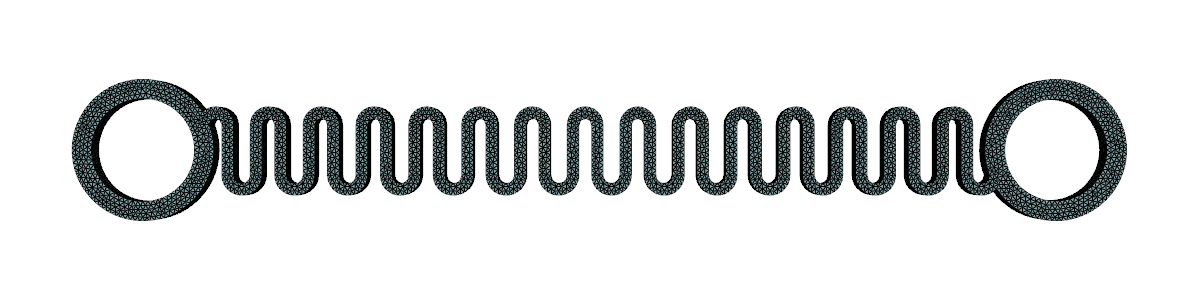

In [19]:
# Visualise the mesh

plotter = pyvista.Plotter(window_size=[1200, 300])
vmesh = vtk_mesh(mesh)
grid = pyvista.UnstructuredGrid(*vmesh);
plotter.add_mesh(grid, show_edges=True)
plotter.camera.position = (0.045, 0.0, 0.2)
plotter.camera.focal_point = (0.045, 0.0, 0.0)
plotter.camera.up = (0.0, 1.0, 0.0)
plotter.camera.zoom(3.5)
plotter.show()

### Set up some data for the problem
Here we will define all the parameters, such as the mass of the spring and weight, the elastic parameters, gravity etc.

In [20]:
# Elastic parameters
E = 1.8e9 # Young's modulus = 1.8 GPa
ν = 0.35  # Poisson ratio
μ = E / (2.0 * (1.0 + ν))
λ = E * ν / ((1.0 + ν) * (1.0 - 2.0 * ν))

def σ(v):
    """Return an expression for the stress σ given a displacement field v"""
    return 2.0 * μ * sym(grad(v)) + λ * tr(sym(grad(v))) * Identity(len(v))

# Applied traction (external force from weight of bolt)
m_bolt = 6.17e-3 # 6.17g
g = np.array((0.0, -9.81, 0.0))
r = 5.05e-3
dz = 3.0e-3
t = Constant(mesh, m_bolt * g / (2 * np.pi * r * dz))

# Body force (self-weight)
m_spring = 1.55e-3 # 1.55g
rho_spring = m_spring / vol
print(f"Spring density = {rho_spring:.2f} kg/m³")
f = Constant(mesh, rho_spring * g)

Spring density = 1103.18 kg/m³


In [21]:
# Define elasticity problem

# Use linear elements, with vector values (3D)
V = functionspace(mesh, ("Lagrange", 1, (mesh.geometry.dim,)))
u, v = TrialFunction(V), TestFunction(V)

# LHS of equation (stress)
a = form(inner(σ(u), grad(v)) * dx)

# RHS of equation (applied forces f in volume, and t on facets "3")
ds = Measure("ds", subdomain_data=facet_tags)
L = form(inner(f, v) * dx + inner(t, v) * ds(3))


The facets of the left-hand ring, tagged "2", are held immobile by the boundary condition. Here, the matrix and vector are built explicitly, and the BCs are applied in a symmetric way using `apply_lifting`.

In [22]:
# Apply boundary conditions (zero displacement on facets "2")
mesh.topology.create_connectivity(2, 3)
facets = facet_tags.find(2)
vec_zero = np.zeros(3)
dofs = locate_dofs_topological(V, entity_dim=2, entities=facets)
bc = dirichletbc(vec_zero, dofs, V=V)

# Build matrix equation
A = assemble_matrix(a, bcs=[bc])
b = assemble_vector(L)
apply_lifting(b.array, [a], bcs=[[bc]])
bc.set(b.array)


Now, solve the system A.u = b using the solver from `scipy.sparse` - this is sufficient for a small enough problem.

In [ ]:

# Solve using scipy
uh = Function(V)
uh.x.array[:] = spsolve(A.to_scipy().tocsr(), b.array)
displacement = uh.x.array[:].reshape((-1, 3))

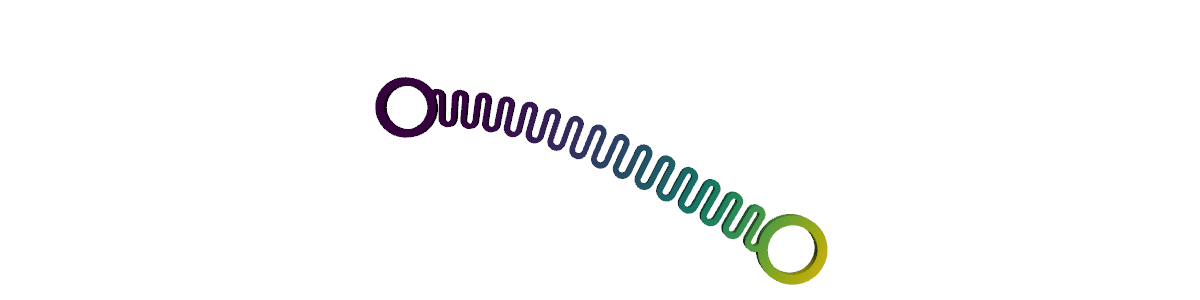

In [14]:
# Replot with displacement
plotter = pyvista.Plotter(window_size=[1200, 300])
grid.point_data["u"] = displacement
grid.set_active_scalars("u")
warped = grid.warp_by_vector("u")
plotter.add_mesh(warped, show_edges=False)
plotter.camera.position = (0.045, 0.0, 0.2)
plotter.camera.focal_point = (0.045, -0.01, 0.0)
plotter.camera.up = (0.0, 1.0, 0.0)
plotter.camera.zoom(1.5)
plotter.remove_scalar_bar()
plotter.show()

In [ ]:
d = np.array([[displacement[:, i].min(), displacement[:, i].max()] for i in range(3)])
d *= 1000.0
print(f"Min/max displacement (mm) is: \n {d}")

Min/max displacement (mm) is: 
 [[-4.09038932e+00  4.23202571e+00]
 [-3.75605891e+01  5.92424253e-03]
 [-1.86970967e-03  4.71013475e-02]]


In [ ]:
# Compute stress field (post-processing)
sigma_dev = σ(uh) - (1 / 3) * tr(σ(uh)) * Identity(len(uh))
sigma_vm = ufl.sqrt((3 / 2) * inner(sigma_dev, sigma_dev))
W = functionspace(mesh, ("Discontinuous Lagrange", 0))
sigma_vm_expr = Expression(sigma_vm, W.element.interpolation_points())
sigma_vm_h = Function(W)
sigma_vm_h.interpolate(sigma_vm_expr)

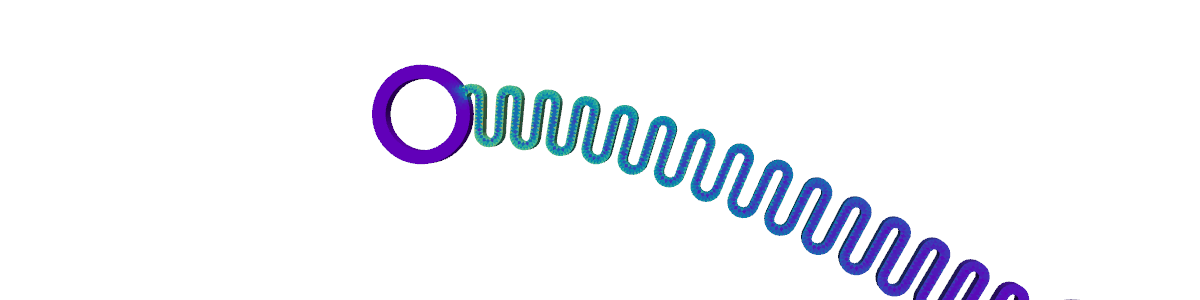

In [ ]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('rainbow', 50)

# Replot with displacement
plotter = pyvista.Plotter(window_size=[1200, 300])
grid.point_data["u"] = displacement
grid.cell_data["sigma_vm"] = sigma_vm_h.x.array
grid.set_active_scalars("sigma_vm")
warped = grid.warp_by_vector("u")
plotter.add_mesh(warped, show_edges=False, cmap=cmap)
plotter.camera.position = (0.045, 0.0, 0.2)
plotter.camera.focal_point = (0.025, -0.005, 0.0)
plotter.camera.up = (0.0, 1.0, 0.0)
plotter.camera.zoom(2.5)
plotter.remove_scalar_bar()
plotter.show()

## Task: change the force to act in the z-direction

You might need to change the visualisation camera position too.

In [ ]:
# Hint: change the vector for gravity "g" and rerun.

## Task: write solution to file
 - output to XDMF format
 - download files (displacement.h5 and displacement.xdmf)
 - open with ParaView

In [ ]:
with XDMFFile(MPI.COMM_WORLD, "displacement.xdmf", "w") as xdmf:
  xdmf.write_mesh(mesh)
  xdmf.write_function(uh, 0.0)